In [46]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import altair as alt

%matplotlib inline

## 1. Data

The data for this project comes from Kaggle. Although I wrangle raw data in other projects I wanted to focus on the rest of preprocessing via pipelining. The the data features car evaluation metrics for classification, such as number of doors, safety, and maintenance cost - each bearing a range of 3-5 categorically ordered values like 'unacc', 'acc', 'vgood', and 'good' for the car_class feature.

##### Data Dictionary
* price    overall price
* buying   buying price
* maint    price of the maintenance
* doors    number of doors
* persons  capacity in terms of persons to carry
* lug_boot the size of luggage boot
* safety   estimated safety of the car The dataset is simple with some minor variation amongst feature variations

data source:
https://archive.ics.uci.edu/ml/datasets/Car+Evaluation


### 1.1 Load & Inspect Data

In [118]:
# 1.1.1 Inspect Table
data = pd.read_csv('../Data/car.data')
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   door      1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 712.2 KB


,buying,maint,door,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [119]:
shape = data.shape
print(f"The {shape[0]} row of data have {shape[1]} features. Since this is a classification problem I'll be selecting one to be the target, leaving me with {shape[1]-1} features to work with.\nAt this point it would seem that door and persons are numeric features but I'll check that shortly.")

The 1728 row of data have 7 features. Since this is a classification problem I'll be selecting one to be the target, leaving me with 6 features to work with.
At this point it would seem that door and persons are numeric features but I'll check that shortly.


In [120]:
#check for dupes
print(len(data[data.duplicated()]))

#check for missing
print(data[data.isnull().any(axis=1)])
print(data.isna().sum())

0
Empty DataFrame
Columns: [buying, maint, door, persons, lug_boot, safety, class]
Index: []
buying      0
maint       0
door        0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


In [121]:
# 1.1.2 Inspect & Modify Columns
data.nunique()


buying      4
maint       4
door        5
persons     3
lug_boot    3
safety      3
class       4
dtype: int64

In [122]:
# 'class' is a problematic name.
data = data.rename({'class': 'car_class'}, axis=1)

In [123]:

for i in data.columns:
    print(i)
    print(data[i].value_counts())
    print(data[i].unique(),'\n')

buying
vhigh    432
low      432
high     432
med      432
Name: buying, dtype: int64
['vhigh' 'high' 'med' 'low'] 

maint
vhigh    432
low      432
high     432
med      432
Name: maint, dtype: int64
['vhigh' 'high' 'med' 'low'] 

door
4        432
2        432
3        432
5more    405
more      27
Name: door, dtype: int64
['2' '3' '4' '5more' 'more'] 

persons
more    576
4       576
2       576
Name: persons, dtype: int64
['2' '4' 'more'] 

lug_boot
big      576
med      576
small    576
Name: lug_boot, dtype: int64
['small' 'med' 'big'] 

safety
low     576
high    576
med     576
Name: safety, dtype: int64
['low' 'med' 'high'] 

car_class
unacc    1210
acc       384
good       69
vgood      65
Name: car_class, dtype: int64
['unacc' 'acc' 'vgood' 'good'] 



While door and persons appear to be numeric variables, they are in fact categorical. The rest are and can be treated as strings for possible processing optimization prior to being transformed.

In [124]:
data.door.value_counts()
# note the clearly categorical values.

4        432
2        432
3        432
5more    405
more      27
Name: door, dtype: int64

In [125]:
#strings = ['buying','maint','lug_boot','safety','class']
# nope, they're all categorical and can be converted to string type.
for i in data.columns:
    data[i] = data[i].astype('string')

data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   buying     1728 non-null   string
 1   maint      1728 non-null   string
 2   door       1728 non-null   string
 3   persons    1728 non-null   string
 4   lug_boot   1728 non-null   string
 5   safety     1728 non-null   string
 6   car_class  1728 non-null   string
dtypes: string(7)
memory usage: 712.2 KB


## 2. EDA

### 2.1 Descriptive Stats


In [127]:
data.describe(include='all')

,buying,maint,door,persons,lug_boot,safety,car_class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,5,3,3,3,4
top,med,med,3,2,small,med,unacc
freq,432,432,432,576,576,576,1210


### 2.2 Visualizing Data

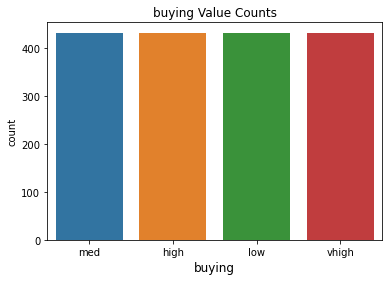

med      432
high     432
low      432
vhigh    432
Name: buying, dtype: Int64


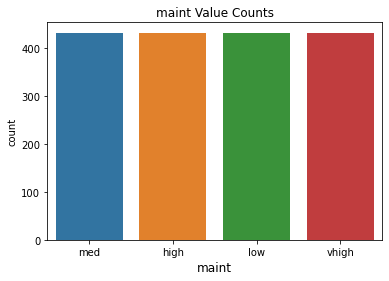

med      432
high     432
low      432
vhigh    432
Name: maint, dtype: Int64


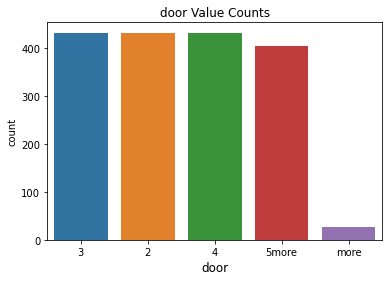

3        432
2        432
4        432
5more    405
more      27
Name: door, dtype: Int64


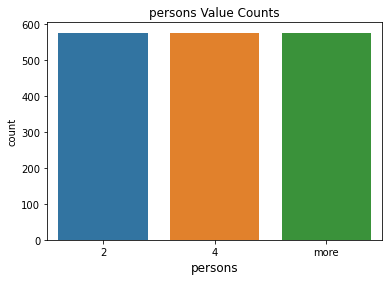

2       576
4       576
more    576
Name: persons, dtype: Int64


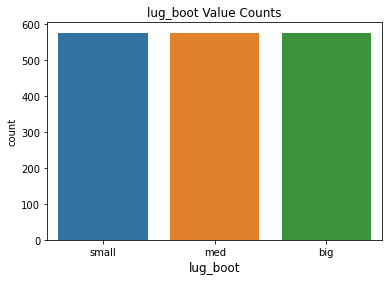

small    576
med      576
big      576
Name: lug_boot, dtype: Int64


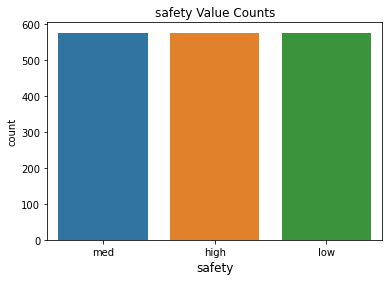

med     576
high    576
low     576
Name: safety, dtype: Int64


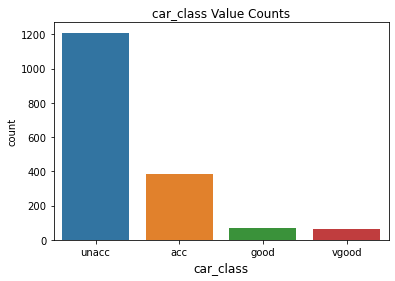

unacc    1210
acc       384
good       69
vgood      65
Name: car_class, dtype: Int64


<Figure size 432x288 with 0 Axes>

In [128]:

# list of all column headers


for column in data.columns.tolist():
  
  
  sns.countplot(x=data[column],order=data[column].value_counts().index)
  plt.title(column+' Value Counts')
  plt.xticks(rotation=0,fontsize=10)
  plt.xlabel(column,fontsize=12)
  plt.show()
  plt.clf()
  print(data[column].value_counts())

### 2.3 EDA Observations
* buying: 
* maint:
* door:
* persons:
* lug_boot:
* safety:
* car_class:

In [72]:
## 2. Preprocessing
### 2.1 Reinspect Data
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   buying     1728 non-null   string
 1   maint      1728 non-null   string
 2   door       1728 non-null   string
 3   persons    1728 non-null   string
 4   lug_boot   1728 non-null   string
 5   safety     1728 non-null   string
 6   car_class  1728 non-null   string
dtypes: string(7)
memory usage: 712.2 KB


,buying,maint,door,persons,lug_boot,safety,car_class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [73]:
### 2.2 Diagnose Data
# This data is extremely clean, which is great for a simple project. ALthough the mostly even splits throughout the data are initially concerning, there doesn't seem to be any significant overlap, at this time.

In [74]:
### 2.3 Data Wrangling
# Since I'd like this to remain a simple KNN project I will need to generate a new column with a target based on a selection of feature values.
# Within the scope of a use case, I may be interested in a low maintenance, relatively safe, and I've got expensive tastes so 

In [75]:
################################################################

In [76]:
data

,buying,maint,door,persons,lug_boot,safety,car_class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [77]:
le = LabelEncoder()
data['car_class'] = le.fit_transform(data.car_class)

In [78]:
X = data.drop(['car_class'],axis=1)
y = data.car_class

In [79]:
x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)

In [80]:
data.buying.value_counts()

med      432
high     432
low      432
vhigh    432
Name: buying, dtype: Int64

In [81]:
### 2.4 Encoding
# For this project I'm keeping ML and train/test splits out of at least the transformation/scaling pipeline.
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

numeric_features = x_train.select_dtypes('number').columns
nominal_features = x_train.select_dtypes('object').columns
ordinal_features = x_train.select_dtypes('string').columns


In [82]:
ordinal_cat_encoder = Pipeline(steps=[
    ('ord_cat',OrdinalEncoder())
])

nominal_encoder = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])

scaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

minmax_scalar_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('ord_cat1', OrdinalEncoder(categories=[['low','med','high','vhigh']]),['buying']),
        ('ord_cat2', OrdinalEncoder(categories=[['low','med','high','vhigh']]),['maint']),
        ('ord_cat3', OrdinalEncoder(categories=[['2', '3', '4', 'more', '5more']]),['door']),
        ('ord_cat5', OrdinalEncoder(categories=[['2', '4', 'more']]),['persons']),
        ('ord_cat4', OrdinalEncoder(categories=[['small', 'med', 'big']]),['lug_boot']),
        ('ord_cat6', OrdinalEncoder(categories=[['low','med','high']]),['safety']),
        #('oe', OneHotEncoder(categories=[['unacc','acc','good','vgood']]),['car_class']),
        #(OrdinalEncoder(categories=['low', 'med', 'high', 'vhigh']), ['buying'])
        #('ohe', nominal_encoder, nominal_cat_features)
        #('scaler', scaler_transformer,scaler_features)
        #('mmax_scaler', minmax_scalar_transformer,scaler_features),

    ],remainder='drop'
)



transformer = Pipeline(steps=[('preprocessor', preprocessor)])
df_transformed = pd.DataFrame(transformer.fit_transform(x_train), columns=x_train.columns)
data = df_transformed
data

,buying,maint,door,persons,lug_boot,safety
0,3.0,3.0,4.0,2.0,2.0,2.0
1,1.0,3.0,1.0,1.0,0.0,1.0
2,0.0,0.0,4.0,0.0,2.0,2.0
3,2.0,1.0,2.0,0.0,1.0,1.0
4,2.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
1377,1.0,1.0,1.0,2.0,1.0,2.0
1378,1.0,0.0,4.0,2.0,2.0,1.0
1379,2.0,0.0,4.0,2.0,1.0,2.0
1380,0.0,2.0,2.0,0.0,0.0,1.0


In [83]:
from sklearn.model_selection import cross_validate



In [84]:
results_dict = {"n_neighbors": list(), "mean_train_score": list(), "mean_cv_score": list()}

for k in range(1, 25):
    pipe = Pipeline(
    steps=[
        ("preprocessor", transformer), 
        ("knn", KNeighborsClassifier(n_neighbors=k))
        ]
    )
    scores = cross_validate(pipe, x_train, y_train, cv=10, return_train_score=True)
    results_dict["n_neighbors"].append(k)
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))

results_df = pd.DataFrame(results_dict)
results_df

,n_neighbors,mean_train_score,mean_cv_score
0,1,1.000000,0.830002
1,2,0.923217,0.821359
2,3,0.968645,0.913169
3,4,0.962292,0.917516
4,5,0.972825,0.937050
5,6,0.968886,0.937775
6,7,0.969851,0.938489
7,8,0.967358,0.934871
8,9,0.962775,0.931243
9,10,0.956585,0.923293


In [85]:
plotting_source = results_df.melt(
    id_vars='n_neighbors',
    value_vars=['mean_train_score', 'mean_cv_score'],
    var_name='score_type',
    value_name='accuracy'
)

K_plot = alt.Chart(plotting_source, width=500, height=300).mark_line().encode(
    alt.X('n_neighbors:Q'),
    alt.Y('accuracy:Q', scale=alt.Scale(domain=[.67, 1.00])),
    alt.Color('score_type:N')
).properties(title="Accuracies of n_neighbors for KNeighborsClassifier")

K_plot

alt.Chart(...)

In [86]:
# going with k = 5

In [87]:
pipe = Pipeline(
    steps=[
        ("preprocessor", transformer), 
        ("knn", KNeighborsClassifier(n_neighbors=5))
        ]
    )
pipe.fit(x_train,y_train)


print("Test accuracy:", round(pipe.score(x_test, y_test),5))

Test accuracy: 0.92775


In [88]:

## 6.2 Evaluate Model Performance
y_pred = pipe.predict(x_test)
probabilities = pipe.predict_proba(x_test)

def evaluate(model,y_pred,y_test):
    """Evaluation function for use with SKlearn algorithms.

    Args:
        model (string): Determines which scoring merics to apply.
        y_pred (_type_): Classifier predictions.
        y_test (_type_): Actual Values
    """
    if model == 'linreg':
        print(linreg.score(x_test,y_test))
        print(linreg.coef_)
        y_pred = linreg.predict(x_test)
        #print(f'The Intercept (grade) is {linreg.intercept_}')
        for i in range(len(y_pred)):
            print(f'Predicted: {round(y_pred[i])}\t Actual: {y_test[i]} \t Data {x_test[i]}')
    if model == 'KNN':
        print(pipe.score(x_test,y_test))
        y_pred = y_pred.tolist()
        y_test = y_test.tolist()
        classes = ['unacc','acc','good','vgood']
        for i in range(len(y_pred)):
            print(f'Pred: {y_pred[i]}\t Actual: {y_test[i]} \t Probability: {probabilities[i]}')
    return

In [89]:
print(evaluate('KNN',y_pred,y_test))

0.9277456647398844
Pred: 2	 Actual: 2 	 Probability: [0.2 0.  0.8 0. ]
Pred: 1	 Actual: 0 	 Probability: [0.2 0.4 0.4 0. ]
Pred: 2	 Actual: 2 	 Probability: [0.2 0.  0.8 0. ]
Pred: 0	 Actual: 0 	 Probability: [0.4 0.  0.4 0.2]
Pred: 2	 Actual: 2 	 Probability: [0.  0.2 0.8 0. ]
Pred: 2	 Actual: 0 	 Probability: [0.4 0.  0.6 0. ]
Pred: 2	 Actual: 2 	 Probability: [0. 0. 1. 0.]
Pred: 2	 Actual: 2 	 Probability: [0.4 0.  0.6 0. ]
Pred: 2	 Actual: 2 	 Probability: [0.2 0.  0.8 0. ]
Pred: 2	 Actual: 2 	 Probability: [0.2 0.  0.8 0. ]
Pred: 0	 Actual: 3 	 Probability: [0.6 0.  0.  0.4]
Pred: 0	 Actual: 0 	 Probability: [0.4 0.4 0.2 0. ]
Pred: 2	 Actual: 2 	 Probability: [0.4 0.  0.6 0. ]
Pred: 2	 Actual: 2 	 Probability: [0.2 0.  0.8 0. ]
Pred: 2	 Actual: 2 	 Probability: [0. 0. 1. 0.]
Pred: 2	 Actual: 2 	 Probability: [0. 0. 1. 0.]
Pred: 2	 Actual: 2 	 Probability: [0.2 0.  0.8 0. ]
Pred: 2	 Actual: 2 	 Probability: [0.  0.2 0.8 0. ]
Pred: 2	 Actual: 2 	 Probability: [0.  0.2 0.8 0. ]
Pred:

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[ 70   6   6   1]
 [  1  10   0   0]
 [  1   0 234   0]
 [  5   5   0   7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        83
           1       0.48      0.91      0.62        11
           2       0.97      1.00      0.99       235
           3       0.88      0.41      0.56        17

    accuracy                           0.93       346
   macro avg       0.81      0.79      0.76       346
weighted avg       0.94      0.93      0.93       346

Accuracy: 0.9277456647398844


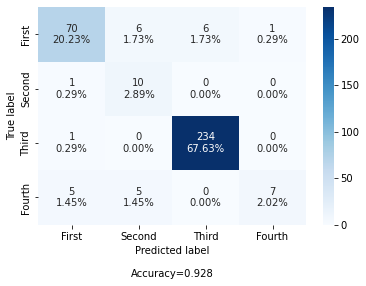

In [91]:
from cf_matrix import make_confusion_matrix

labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["First", "Second",'Third','Fourth']
make_confusion_matrix(result, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [92]:
#TODO get and possibly plot distances
#TODO apply gridsearch?
#TODO make probabilities more interpretable
#TODO make eval function.. better
#TODO add more EDA graphs for groupings and variable comparisons (stats)
#TODO can this be self-tuning w/gridsearch?

#TODO ### 1.5 Observations
#TODO chi square!

In [93]:
# DENOTES
# May.4
# something interesting that just happened is that I realized, a little latr, that using car_class would have created a multilabel problem.
    # I found this, might be worth looking into later. http://scikit.ml/api/skmultilearn.adapt.mlknn.html
    # For now, the problem has (thankfully) evolved into a simpler direction where I compose a target, based on what features I might wat to see in a car.
